In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Fri Nov 25 12:36:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |      

In [ ]:
%%writefile vectorAdd.cu
#include <stdio.h>
#include <stdlib.h>

__global__ void add(int *a, int *b, int *c) {
  *c = *a + *b;
}

int main() {
  int a, b, c;

  // host copies of variables a, b & c
  int *d_a, *d_b, *d_c;

  // device copies of variables a, b & c
  int size = sizeof(int);

  // Allocate space for device copies of a, b, c
  cudaMalloc((void **)&d_a, size);
  cudaMalloc((void **)&d_b, size);
  cudaMalloc((void **)&d_c, size);

  // Setup input values  
  c = 0;
  a = 3;
  b = 5;

  // Copy inputs to device
  cudaMemcpy(d_a, &a, size, cudaMemcpyHostToDevice);
  cudaMemcpy(d_b, &b, size, cudaMemcpyHostToDevice);

  // Launch add() kernel on GPU
  add<<<1,1>>>(d_a, d_b, d_c);

  // Copy result back to host
  cudaError err = cudaMemcpy(&c, d_c, size, cudaMemcpyDeviceToHost);
  if(err!=cudaSuccess) {
      printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
  }

  printf("result is %d\n",c);

  // Cleanup
  cudaFree(d_a);
  cudaFree(d_b);
  cudaFree(d_c);
  return 0;
}

Writing vectorAdd.cu


In [ ]:
!nvcc vectorAdd.cu
!ls
!./a.out

a.out  sample_data  vectorAdd.cu
result is 8


In [ ]:
!ls /usr/local/cuda*

/usr/local/cuda:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11.2:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json


In [ ]:
!cp -rf /usr/local/cuda-11/samples/1_Utilities/bandwidthTest ./bandwidthTest

In [ ]:
!ls bandwidthTest
!nvcc -I/usr/local/cuda-11/samples/common/inc bandwidthTest/bandwidthTest.cu -o bandwidthTest/bandwidthTest

bandwidthTest.cu  Makefile  NsightEclipse.xml  readme.txt


In [ ]:
!./bandwidthTest/bandwidthTest

[CUDA Bandwidth Test] - Starting...
Running on...

 Device 0: Tesla T4
 Quick Mode

 Host to Device Bandwidth, 1 Device(s)
 PINNED Memory Transfers
   Transfer Size (Bytes)	Bandwidth(GB/s)
   32000000			12.3

 Device to Host Bandwidth, 1 Device(s)
 PINNED Memory Transfers
   Transfer Size (Bytes)	Bandwidth(GB/s)
   32000000			13.1

 Device to Device Bandwidth, 1 Device(s)
 PINNED Memory Transfers
   Transfer Size (Bytes)	Bandwidth(GB/s)
   32000000			239.4

Result = PASS

NOTE: The CUDA Samples are not meant for performance measurements. Results may vary when GPU Boost is enabled.


In [ ]:
!./bandwidthTest/bandwidthTest --mode=shmoo --csv > benchmark.txt

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

In [ ]:
def is_decimal(s): 
  try: 
    float(s)
    return True
  except ValueError: 
    return False

def extract_decimal(txt): 
  return [float(s) for s in txt.split() if is_decimal(s)][0]

converters = {
    0: lambda x: x[14:],
    1: extract_decimal, 
    2: extract_decimal, 
    3: extract_decimal, 
    4: extract_decimal, 
}

columns = {
    0: "type", 
    1: "bandwidth(gb/s)", 
    2: "time(s)", 
    3: "size(bytes)", 
    4: "numdevices", 
}

file = open("./benchmark.txt", "r")
df = pd.read_csv(file, header=None, converters=converters)
df = df.rename(columns, axis=1).drop("numdevices", axis=1)
df.to_csv("./benchmark.csv")

h2d_df = df[df['type'] == "H2D-Pinned"]
d2h_df = df[df['type'] == "D2H-Pinned"]
d2d_df = df[df['type'] == "D2D"]

h2d_df.head(), d2h_df.head(), d2d_df.head()

(         type  bandwidth(gb/s)  time(s)  size(bytes)
 0  H2D-Pinned              0.4      0.0       1000.0
 1  H2D-Pinned              0.8      0.0       2000.0
 2  H2D-Pinned              1.2      0.0       3000.0
 3  H2D-Pinned              1.5      0.0       4000.0
 4  H2D-Pinned              1.8      0.0       5000.0,
           type  bandwidth(gb/s)  time(s)  size(bytes)
 81  D2H-Pinned              0.7      0.0       1000.0
 82  D2H-Pinned              1.4      0.0       2000.0
 83  D2H-Pinned              2.1      0.0       3000.0
 84  D2H-Pinned              2.6      0.0       4000.0
 85  D2H-Pinned              3.1      0.0       5000.0,
     type  bandwidth(gb/s)  time(s)  size(bytes)
 162  D2D              0.6      0.0       1000.0
 163  D2D              1.1      0.0       2000.0
 164  D2D              1.8      0.0       3000.0
 165  D2D              2.4      0.0       4000.0
 166  D2D              3.1      0.0       5000.0)

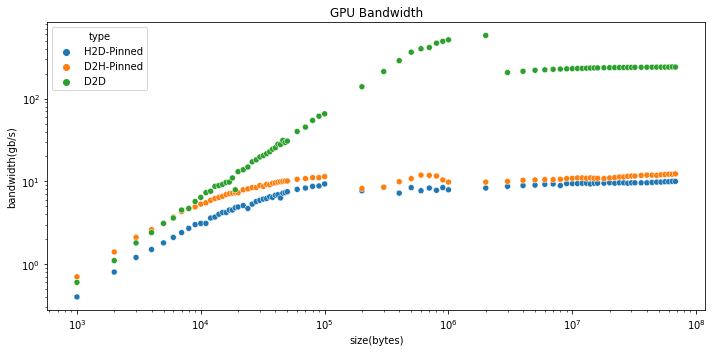

In [ ]:
grid = sns.scatterplot(x="size(bytes)", y="bandwidth(gb/s)", hue="type", data=df)
grid.set(xscale="log", yscale="log", title="GPU Bandwidth")
grid

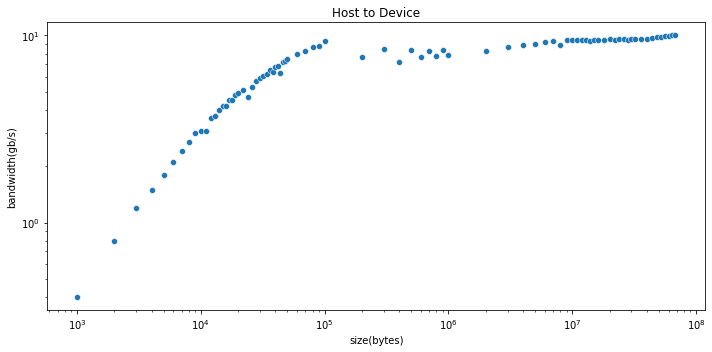

In [ ]:
grid = sns.scatterplot(x="size(bytes)", y="bandwidth(gb/s)", data=h2d_df)
grid.set(xscale="log", yscale="log", title="Host to Device")
grid

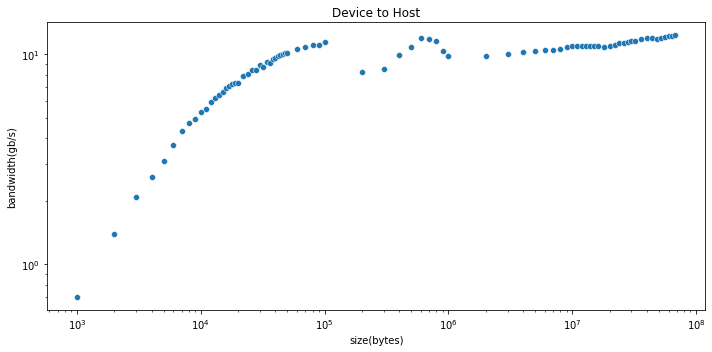

In [ ]:
grid = sns.scatterplot(x="size(bytes)", y="bandwidth(gb/s)", data=d2h_df)
grid.set(xscale="log", yscale="log", title="Device to Host")
grid

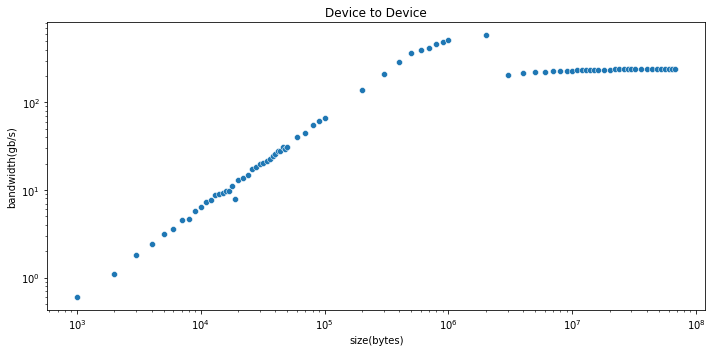

In [ ]:
grid = sns.scatterplot(x="size(bytes)", y="bandwidth(gb/s)", data=d2d_df)
grid.set(xscale="log", yscale="log", title="Device to Device")
grid